Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,939 (109.14 KB)

 Trainable params: 27,939 (109.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
25/25 - 8s - 304ms/step - accuracy: 0.6475 - loss: 0.9289 - val_accuracy: 1.0000 - val_loss: 0.4784
Epoch 2/6
25/25 - 3s - 139ms/step - accuracy: 0.9937 - loss: 0.1446 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/6
25/25 - 3s - 122ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 1.0612e-04
Epoch 4/6
25/25 - 3s - 125ms/step - accuracy: 1.0000 - loss: 7.4003e-04 - val_accuracy: 1.0000 - val_loss: 4.1302e-05
Epoch 5/6
25/25 - 4s - 173ms/step - accuracy: 1.0000 - loss: 4.2548e-04 - val_accuracy: 1.0000 - val_loss: 3.3306e-05
Epoch 6/6
25/25 - 3s - 126ms/step - accuracy: 1.0000 - loss: 3.1825e-04 - val_accuracy: 1.0000 - val_loss: 1.9600e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Saved artifact at '/tmp/tmpyr7epkfx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139276716309008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276716309200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710265296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710265104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710265680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710267408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276716309392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710267024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710266256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139276710267216: TensorSpec(shape=(), dtype=tf.resource, name=None)
SUMMARY: {
  "test

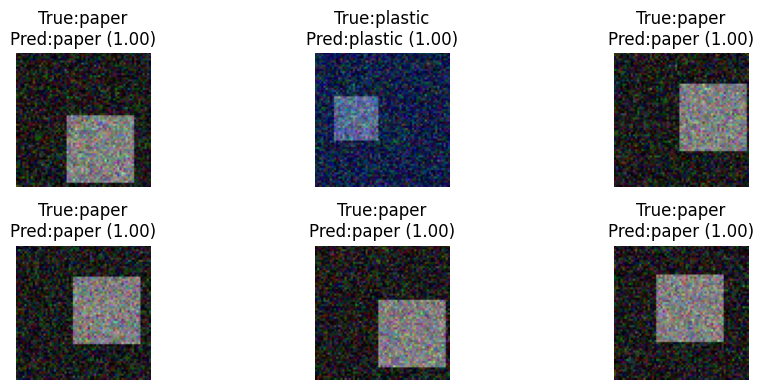

In [ ]:
# Colab-ready Edge AI prototype: train -> convert to TFLite -> evaluate
# Run in Google Colab (TF installed) or install TensorFlow locally: pip install tensorflow

import os, json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ---- params ----
IMG_SIZE = 64
NUM_CLASSES = 3
CLASS_NAMES = ["plastic", "paper", "glass"]
TRAIN_SAMPLES = 800
VAL_SAMPLES = 200
TEST_SAMPLES = 200
BATCH_SIZE = 32
EPOCHS = 6
OUT_DIR = "/content/edge_output"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- synthetic dataset generator (fast offline demo) ----
def generate_synthetic_images(num_samples, img_size, num_classes):
    X = np.zeros((num_samples, img_size, img_size, 3), dtype=np.float32)
    y = np.zeros((num_samples,), dtype=np.int32)
    for i in range(num_samples):
        cls = np.random.randint(0, num_classes)
        y[i] = cls
        img = np.random.normal(loc=0.0, scale=0.12, size=(img_size, img_size, 3)).astype(np.float32)
        if cls == 0:  # plastic -> bluish rectangle
            img += np.array([0.05, 0.12, 0.28])
            x0 = np.random.randint(img_size//8, img_size//2)
            y0 = np.random.randint(img_size//8, img_size//2)
            img[y0:y0+img_size//3, x0:x0+img_size//3, :] += 0.3
        elif cls == 1:  # paper -> whitish patch
            img += 0.1
            x0 = np.random.randint(img_size//6, img_size//2)
            y0 = np.random.randint(img_size//6, img_size//2)
            img[y0:y0+img_size//2, x0:x0+img_size//2, :] += 0.4
        else:  # glass -> greenish circular highlight
            img += np.array([0.0, 0.18, 0.08])
            rr, cc = np.ogrid[:img_size, :img_size]
            center = (np.random.randint(img_size//4, img_size*3//4), np.random.randint(img_size//4, img_size*3//4))
            mask = (rr - center[0])**2 + (cc - center[1])**2 <= (img_size//5)**2
            img[mask, :] += 0.35
        img = np.clip(img, 0, 1.0)
        X[i] = img
    return X, y

# Create train, val, test
X_train, y_train = generate_synthetic_images(TRAIN_SAMPLES, IMG_SIZE, NUM_CLASSES)
X_val, y_val = generate_synthetic_images(VAL_SAMPLES, IMG_SIZE, NUM_CLASSES)
X_test, y_test = generate_synthetic_images(TEST_SAMPLES, IMG_SIZE, NUM_CLASSES)

# ---- lightweight CNN ----
def make_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = make_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ---- train ----
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# ---- evaluate ----
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)
cm = confusion_matrix(y_test, y_pred)

# ---- save Keras model ----
keras_path = os.path.join(OUT_DIR, "edge_model_recyclables.h5")
model.save(keras_path)

# ---- convert to TFLite (default optimization) ----
tflite_path = os.path.join(OUT_DIR, "edge_model_recyclables.tflite")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Optional: full integer quantization: uncomment and provide representative dataset
# def representative_data_gen():
#     for i in range(100):
#         yield [X_train[i:i+1].astype(np.float32)]
# converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

# ---- sizes ----
keras_kb = os.path.getsize(keras_path) / 1024
tflite_kb = os.path.getsize(tflite_path) / 1024

# ---- print summary ----
summary = {
    "test_accuracy": float(test_acc),
    "test_loss": float(test_loss),
    "keras_kb": round(keras_kb,2),
    "tflite_kb": round(tflite_kb,2),
    "keras_path": keras_path,
    "tflite_path": tflite_path
}
print("SUMMARY:", json.dumps(summary, indent=2))
print("\nCLASSIFICATION REPORT:\n", report)
print("\nCONFUSION MATRIX:\n", cm)

# ---- show sample predictions ----
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[i])
    plt.title(f"True:{CLASS_NAMES[y_test[i]]}\nPred:{CLASS_NAMES[y_pred[i]]} ({y_pred_probs[i].max():.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()
